<a href="https://colab.research.google.com/github/falahamro/Moral-Foundations-Analysis/blob/main/Mapping_Moral_Foundations_of_Republicans_and_Democrats_in_Election_Campain_Speeches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import plotly.offline as py
import plotly.graph_objs as go

# Moral Foundations Analysis

In [ ]:
# Load the data: speech transcripts from 2016 US Presidential campaigns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
campaign = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/campaign_2016.csv", index_col=0)

In [ ]:
campaign.head()

,Candidate,Party,Type,Date,Title,Text
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...


In [ ]:
# get basic summary statistics about the data

# We first look at the unique candidates

campaign['Candidate'].unique()

array(['Jeb Bush', 'Ben Carson', 'Lincoln Chafee', 'Chris Christie',
       'Hillary Clinton ', 'Ted Cruz', 'Carly Fiorina', 'Lindsey Graham',
       'Mike Huckabee', 'Bobby Jindal', 'John Kasich', "Martin O'Malley",
       'George Pataki', 'Rand Paul', 'Rick Perry', 'Marco Rubio',
       'Bernie Sanders', 'Rick Santorum', 'Donald Trump', 'Scott Walker',
       'Jim Webb'], dtype=object)

In [ ]:
# Look at the duplicated texts

campaign['Text'].value_counts()[campaign['Text'].value_counts() > 1]

To view this video please enable JavaScript, and consider upgrading to a web browser thatsupports HTML5 video                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
# Find out if there are null values

campaign.isnull().sum()

Candidate      0
Party          0
Type           0
Date           0
Title          0
Text         124
dtype: int64

In [ ]:
campaign[campaign.isnull().any(axis=1)]

,Candidate,Party,Type,Date,Title,Text
10,Jeb Bush,R,press release,"June 15, 2015",Press Release - I Know We Can Fix This,NaN
11,Jeb Bush,R,press release,"June 15, 2015",Press Release - I Will Run To Win,NaN
12,Jeb Bush,R,press release,"June 16, 2015",Press Release - Best Part of Announcement Day,NaN
13,Jeb Bush,R,press release,"June 16, 2015",Press Release - #JebNoFilter: New Hampshire Ed...,NaN
14,Jeb Bush,R,press release,"June 16, 2015",Press Release - Preparing,NaN
...,...,...,...,...,...,...
6875,Rick Santorum,R,press release,"March 7, 2012",Press Release - An Interview with Karen Santorum,NaN
7161,Donald Trump,R,press release,"November 9, 2015",Press Release - Donald Trump Monologue - SNL,NaN
7230,Donald Trump,R,press release,"January 31, 2016",Press Release - Ivanka Trump - Find Your Iowa ...,NaN
7248,Donald Trump,R,press release,"February 20, 2016",Press Release - Donald J. Trump South Carolina...,NaN


In [ ]:
# let's drop the null values with dropna

campaign.dropna(inplace=True)

In [ ]:
campaign.describe()

,Candidate,Party,Type,Date,Title,Text
count,7361,7361,7361,7361,7361,7361
unique,21,2,3,1193,7196,7328
top,Hillary Clinton,R,press release,"February 29, 2016",Press Release - Yesterday in the States,"To view this video please enable JavaScript, a..."
freq,2504,4083,6090,34,18,10


OBSERVATIONS: 



1.   There are 7485 records but only 7361 texts, and only 7328 unique texts. We would expect that every record should have a unique text. This implies there are null or duplicate values.
2.   A few texts are duplicated (included as both press releases and statements), which could give an erroneous view of the content or frequency of a candidate's speech.


1.   There are 124 null-valued texts. From the titles, we can intuit that these are mostly videos. And, many of the duplicate texts also appear to be videos from their titles. This could affect text analysis: maybe politicians are more likely to talk to certain audiences or about certain topics using videos, which could skew our analysis.


As can be seen, there are a handful of null values in the 'Text' column. Null values can mess up calculations and need to be dealt with by filling them with a dummy value or deleting the row. Because the null values are for text, and because we're most interested in the text content, we'll drop the offending rows. How you deal with null values will vary on a project-by-project basis.





In [ ]:
# Let's drop the null-valued rows with dropna
campaign.dropna(inplace=True)

**Feature extraction**

the number of characters per text

the number of words per text

the number of sentences per text

the average length of words per text

the average length of sentences per text

In [ ]:
import nltk
import ssl

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# we'll extract features from text data


campaign['clean_text'] = campaign['Text'].str.lower()
campaign['words'] = campaign['clean_text'].apply(nltk.word_tokenize)
campaign['sentences'] = campaign['clean_text'].apply(nltk.sent_tokenize)

In [ ]:
campaign.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco..."
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h..."
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al..."
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi..."
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so..."


In [ ]:
# We calculate the len on each column that has text
campaign['char_count'] = campaign['clean_text'].str.len()
campaign['word_count'] = campaign['words'].str.len()
campaign['sentence_count'] = campaign['sentences'].str.len()
campaign['avg_word_length'] = campaign['char_count'] / campaign['word_count']
campaign['avg_sentence_length'] = campaign['word_count'] / campaign['sentence_count']

In [ ]:
campaign

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,2338,47,5.296407,49.744681
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,2868,126,5.040795,22.761905
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,4061,132,5.240827,30.765152
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,2030,92,4.950246,22.065217
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,2564,37,5.533931,69.297297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7480,Scott Walker,R,statement,"September 11, 2015",Statement by Governor Walker on the 14th Anniv...,"Milwaukee, Wis. -- Today, Gov. Scott Walker re...","milwaukee, wis. -- today, gov. scott walker re...","[milwaukee, ,, wis., --, today, ,, gov, ., sco...","[milwaukee, wis. -- today, gov., scott walker ...",928,170,7,5.458824,24.285714
7481,Scott Walker,R,statement,"September 11, 2015",Statement by Governor Walker on the Three-Year...,"Milwaukee, Wis. -- Gov. Scott Walker issued th...","milwaukee, wis. -- gov. scott walker issued th...","[milwaukee, ,, wis., --, gov, ., scott, walker...","[milwaukee, wis. -- gov., scott walker issued ...",733,135,6,5.429630,22.500000
7482,Jim Webb,D,speech,"September 24, 2015","Remarks in RFD-TVs ""Rural Town Hall"" West Des ...",OPPOLD:And from the beautiful Stine's Family B...,oppold:and from the beautiful stine's family b...,"[oppold, :, and, from, the, beautiful, stine, ...",[oppold:and from the beautiful stine's family ...,47284,9679,12,4.885215,806.583333
7483,Jim Webb,D,statement,"July 2, 2015",Statement Announcing Candidacy for President,"Dear friends:After many months of thought, del...","dear friends:after many months of thought, del...","[dear, friends, :, after, many, months, of, th...","[dear friends:after many months of thought, de...",11944,2208,52,5.409420,42.461538


In [ ]:
# Let's convert the Date colun to type datetime

campaign['datetime'] = pd.to_datetime(campaign['Date'])

campaign.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,datetime
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,2338,47,5.296407,49.744681,2015-06-15
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,2868,126,5.040795,22.761905,2015-07-30
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,4061,132,5.240827,30.765152,2015-08-11
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,2030,92,4.950246,22.065217,2015-09-09
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,2564,37,5.533931,69.297297,2015-11-02


Text(0.5, 1.0, 'word count')

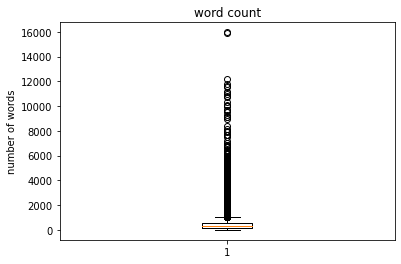

In [ ]:
# let's make a boxplot of the word counts

plt.boxplot(campaign['word_count'])
plt.ylabel('number of words')
plt.title('word count')

We can see that over half of our texts contain less than a thousand words, but many texts contain several times that.

Let's a dataframe that only has type 'speech', and another dataframe that only has type 'statement'. Then, we make a box plot for each. we compare the box plots for word counts to those for word length, sentence length, or character count.

Text(0.5, 1.0, 'speech word count')

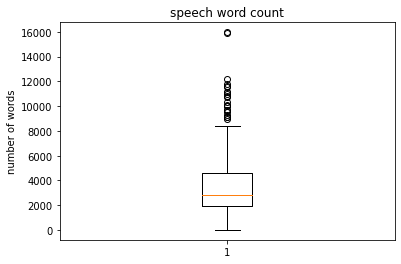

In [ ]:
campaign = campaign[campaign['Type'] == 'speech']
plt.boxplot(campaign['word_count'])
plt.ylabel('number of words')
plt.title('speech word count')

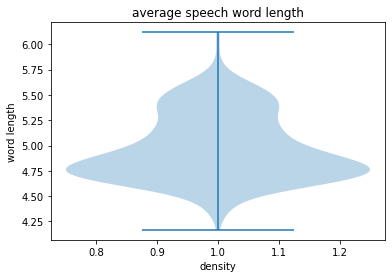

In [ ]:
plt.violinplot(campaign['avg_word_length'])
plt.ylabel('word length')
plt.xlabel('density')
plt.title('average speech word length');

# Principal Components Analysis

In [ ]:
from nltk.stem.snowball import SnowballStemmer
import os
import re
import json

Moral Foundations Dictionary 

A quanteda dictionary object containing the Moral Foundations Dictionary, a publicly available dictionaries with information on the proportions of virtue and vice words for each foundation. The categories are harm (vice/virtue), fairness (vice/virtue), ingroup (vice/virtue), authority (vice/virtue), purity (vice/virtue) and morality (general).



In [ ]:
# Let's load the dictionary into the mft_dict variable

with open('/content/drive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/foundations_dict.json') as json_data:
    mft_dict = json.load(json_data)

# Stem the words in your dictionary (this will help you get more matches)
stemmer = SnowballStemmer('english')

for foundation in mft_dict.keys():
    curr_words = mft_dict[foundation]
    stemmed_words = [stemmer.stem(word) for word in curr_words]
    mft_dict[foundation] = stemmed_words

In [ ]:
# Stem the words in your dictionary (this will help you get more matches)
stemmer = SnowballStemmer('english')

for foundation in mft_dict.keys():
    curr_words = mft_dict[foundation]
    stemmed_words = [stemmer.stem(word) for word in curr_words]
    mft_dict[foundation] = stemmed_words

In [ ]:
# Let's view the dictionary keys using the .key() function:

keys = mft_dict.keys()
list(keys)

['authority/subversion',
 'care/harm',
 'fairness/cheating',
 'liberty/oppression',
 'loyalty/betrayal',
 'sanctity/degradation']

In [ ]:
# Check the entries associated with a key in brackets

mft_dict

{'authority/subversion': ['respect',
  'esteem',
  'regard',
  'subver',
  'say-so',
  'offic',
  'disrespect',
  'valu',
  'obedi',
  'assur',
  'honor',
  'disesteem',
  'agenc',
  'corrupt',
  'honour',
  'domin',
  'author',
  'observ',
  'confid',
  'defer',
  'bureau',
  'authori',
  'sure',
  'sanction'],
 'care/harm': ['hurt',
  'scath',
  'precaut',
  'concern',
  'attent',
  'damag',
  'care',
  'manag',
  'impair',
  'worri',
  'harm',
  'trauma',
  'guardianship',
  'aid',
  'tend',
  'caution',
  'forethought',
  'tutelag',
  'injuri',
  'upkeep',
  'mainten',
  'charg'],
 'fairness/cheating': ['equiti',
  'fair',
  'cuckold',
  'unsportsmanlik',
  'screw',
  'dirti',
  'candour',
  'cheat',
  'proport',
  'balanc',
  'inequ',
  'chican',
  'betray',
  'candor',
  'adult',
  'chous',
  'unsport',
  'unfair',
  'two-tim',
  'foul',
  'shaft',
  'fair-mind'],
 'liberty/oppression': ['self-direct',
  'self-suffici',
  'autonomi',
  'conquest',
  'burdensom',
  'independ',
  '

Observations: 

Note the enries in the dictionary have been stemmed. In other words, they have been reduced to their smallest meaningful root. 

In [ ]:
# Let's try and check the number of times a second string appears in the first string


"Data science is the best major, says data scientist.".count('science')

1

In [ ]:
# Let's try the lower function: 

"Rhetoric major says back: NEVER argue with a rhetoric student.".lower()

'rhetoric major says back: never argue with a rhetoric student.'

In [ ]:
def clean_text(text):
    # remove punctuation using a regular expression (not covered in these modules)
    p = re.compile(r'[^\w\s]')
    no_punc = p.sub(' ', text)
    # convert to lowercase
    no_punc_lower = no_punc.lower()
    # split into individual words
    clean = no_punc_lower.split()
    return clean
    
campaign['clean_speech'] = [clean_text(s) for s in campaign['Text']]

campaign.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,datetime,clean_speech
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,2338,47,5.296407,49.744681,2015-06-15,"[thank, you, all, very, much, i, always, feel,..."
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,2868,126,5.040795,22.761905,2015-07-30,"[thank, you, all, very, much, i, appreciate, y..."
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,4061,132,5.240827,30.765152,2015-08-11,"[thank, you, very, much, it, s, good, to, be, ..."
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,2030,92,4.950246,22.065217,2015-09-09,"[thank, you, very, much, i, appreciate, your, ..."
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,2564,37,5.533931,69.297297,2015-11-02,"[thank, you, it, s, great, to, be, in, tampa, ..."


In [ ]:
# create a new column called 'total_words'
campaign['total_words'] = [len(speech) for speech in campaign['clean_speech']]
campaign.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,datetime,clean_speech,total_words
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,2338,47,5.296407,49.744681,2015-06-15,"[thank, you, all, very, much, i, always, feel,...",2284
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,2868,126,5.040795,22.761905,2015-07-30,"[thank, you, all, very, much, i, appreciate, y...",2638
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,4061,132,5.240827,30.765152,2015-08-11,"[thank, you, very, much, it, s, good, to, be, ...",3735
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,2030,92,4.950246,22.065217,2015-09-09,"[thank, you, very, much, i, appreciate, your, ...",1880
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,2564,37,5.533931,69.297297,2015-11-02,"[thank, you, it, s, great, to, be, in, tampa, ...",2550


In [ ]:
#Note: much of the following code is not covered in these modules. Read the comments to get a sense of what it does.

# do the following code for each foundation
for foundation in mft_dict.keys():
    # create a new, empty column
    num_match_words = np.zeros(len(campaign))
    stems = mft_dict[foundation]
    
    # do the following code for each foundation word
    for stem in stems:
        # find synonym matches
        wd_count = np.array([sum([wd.startswith(stem) for wd in speech]) for speech in campaign['clean_speech']])
        # add the number of matches to the total
        num_match_words += wd_count
        
    # create a new column for each foundation with the number of foundation words per speech
    campaign[foundation] = num_match_words

campaign.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,...,avg_sentence_length,datetime,clean_speech,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,...,49.744681,2015-06-15,"[thank, you, all, very, much, i, always, feel,...",2284,4.0,4.0,3.0,0.0,7.0,4.0
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,...,22.761905,2015-07-30,"[thank, you, all, very, much, i, appreciate, y...",2638,8.0,2.0,7.0,0.0,4.0,9.0
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,...,30.765152,2015-08-11,"[thank, you, very, much, it, s, good, to, be, ...",3735,12.0,5.0,1.0,0.0,4.0,5.0
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,...,22.065217,2015-09-09,"[thank, you, very, much, i, appreciate, your, ...",1880,3.0,1.0,1.0,0.0,1.0,4.0
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,...,69.297297,2015-11-02,"[thank, you, it, s, great, to, be, in, tampa, ...",2550,8.0,3.0,1.0,1.0,0.0,7.0


In [ ]:
# We divide the number of matched words by the number of total words and multiply by 100

for foundation in mft_dict.keys():
    campaign[foundation] = (campaign[foundation] / campaign['total_words']) * 100

campaign.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,...,avg_sentence_length,datetime,clean_speech,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,...,49.744681,2015-06-15,"[thank, you, all, very, much, i, always, feel,...",2284,0.175131,0.175131,0.131349,0.000000,0.306480,0.175131
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,...,22.761905,2015-07-30,"[thank, you, all, very, much, i, appreciate, y...",2638,0.303260,0.075815,0.265353,0.000000,0.151630,0.341168
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,...,30.765152,2015-08-11,"[thank, you, very, much, it, s, good, to, be, ...",3735,0.321285,0.133869,0.026774,0.000000,0.107095,0.133869
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,...,22.065217,2015-09-09,"[thank, you, very, much, i, appreciate, your, ...",1880,0.159574,0.053191,0.053191,0.000000,0.053191,0.212766
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,...,69.297297,2015-11-02,"[thank, you, it, s, great, to, be, in, tampa, ...",2550,0.313725,0.117647,0.039216,0.039216,0.000000,0.274510


Associations and distributions

In [ ]:
campaign.corr()

,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation
char_count,1.000000,0.994885,0.854876,-0.134035,0.022705,0.998011,-0.103234,0.018087,0.050130,-0.043585,0.005400,-0.129760
word_count,0.994885,1.000000,0.890817,-0.215433,0.001708,0.998354,-0.124390,0.015341,0.041282,-0.056405,0.000826,-0.128083
sentence_count,0.854876,0.890817,1.000000,-0.421230,-0.226714,0.868809,-0.160082,0.011832,0.026358,-0.082233,-0.007352,-0.089451
avg_word_length,-0.134035,-0.215433,-0.421230,1.000000,0.303163,-0.176677,0.327019,-0.050382,0.088012,0.137036,-0.020112,0.018495
avg_sentence_length,0.022705,0.001708,-0.226714,0.303163,1.000000,0.021961,0.157316,-0.051445,-0.027176,0.003046,-0.068631,-0.030443
total_words,0.998011,0.998354,0.868809,-0.176677,0.021961,1.000000,-0.113361,0.015736,0.044444,-0.052027,0.001517,-0.129440
authority/subversion,-0.103234,-0.124390,-0.160082,0.327019,0.157316,-0.113361,1.000000,-0.064078,0.058542,0.029115,0.035874,0.221567
care/harm,0.018087,0.015341,0.011832,-0.050382,-0.051445,0.015736,-0.064078,1.000000,-0.001272,0.007080,0.003034,-0.018015
fairness/cheating,0.050130,0.041282,0.026358,0.088012,-0.027176,0.044444,0.058542,-0.001272,1.000000,-0.033713,-0.037136,-0.019747
liberty/oppression,-0.043585,-0.056405,-0.082233,0.137036,0.003046,-0.052027,0.029115,0.007080,-0.033713,1.000000,0.097022,0.015651


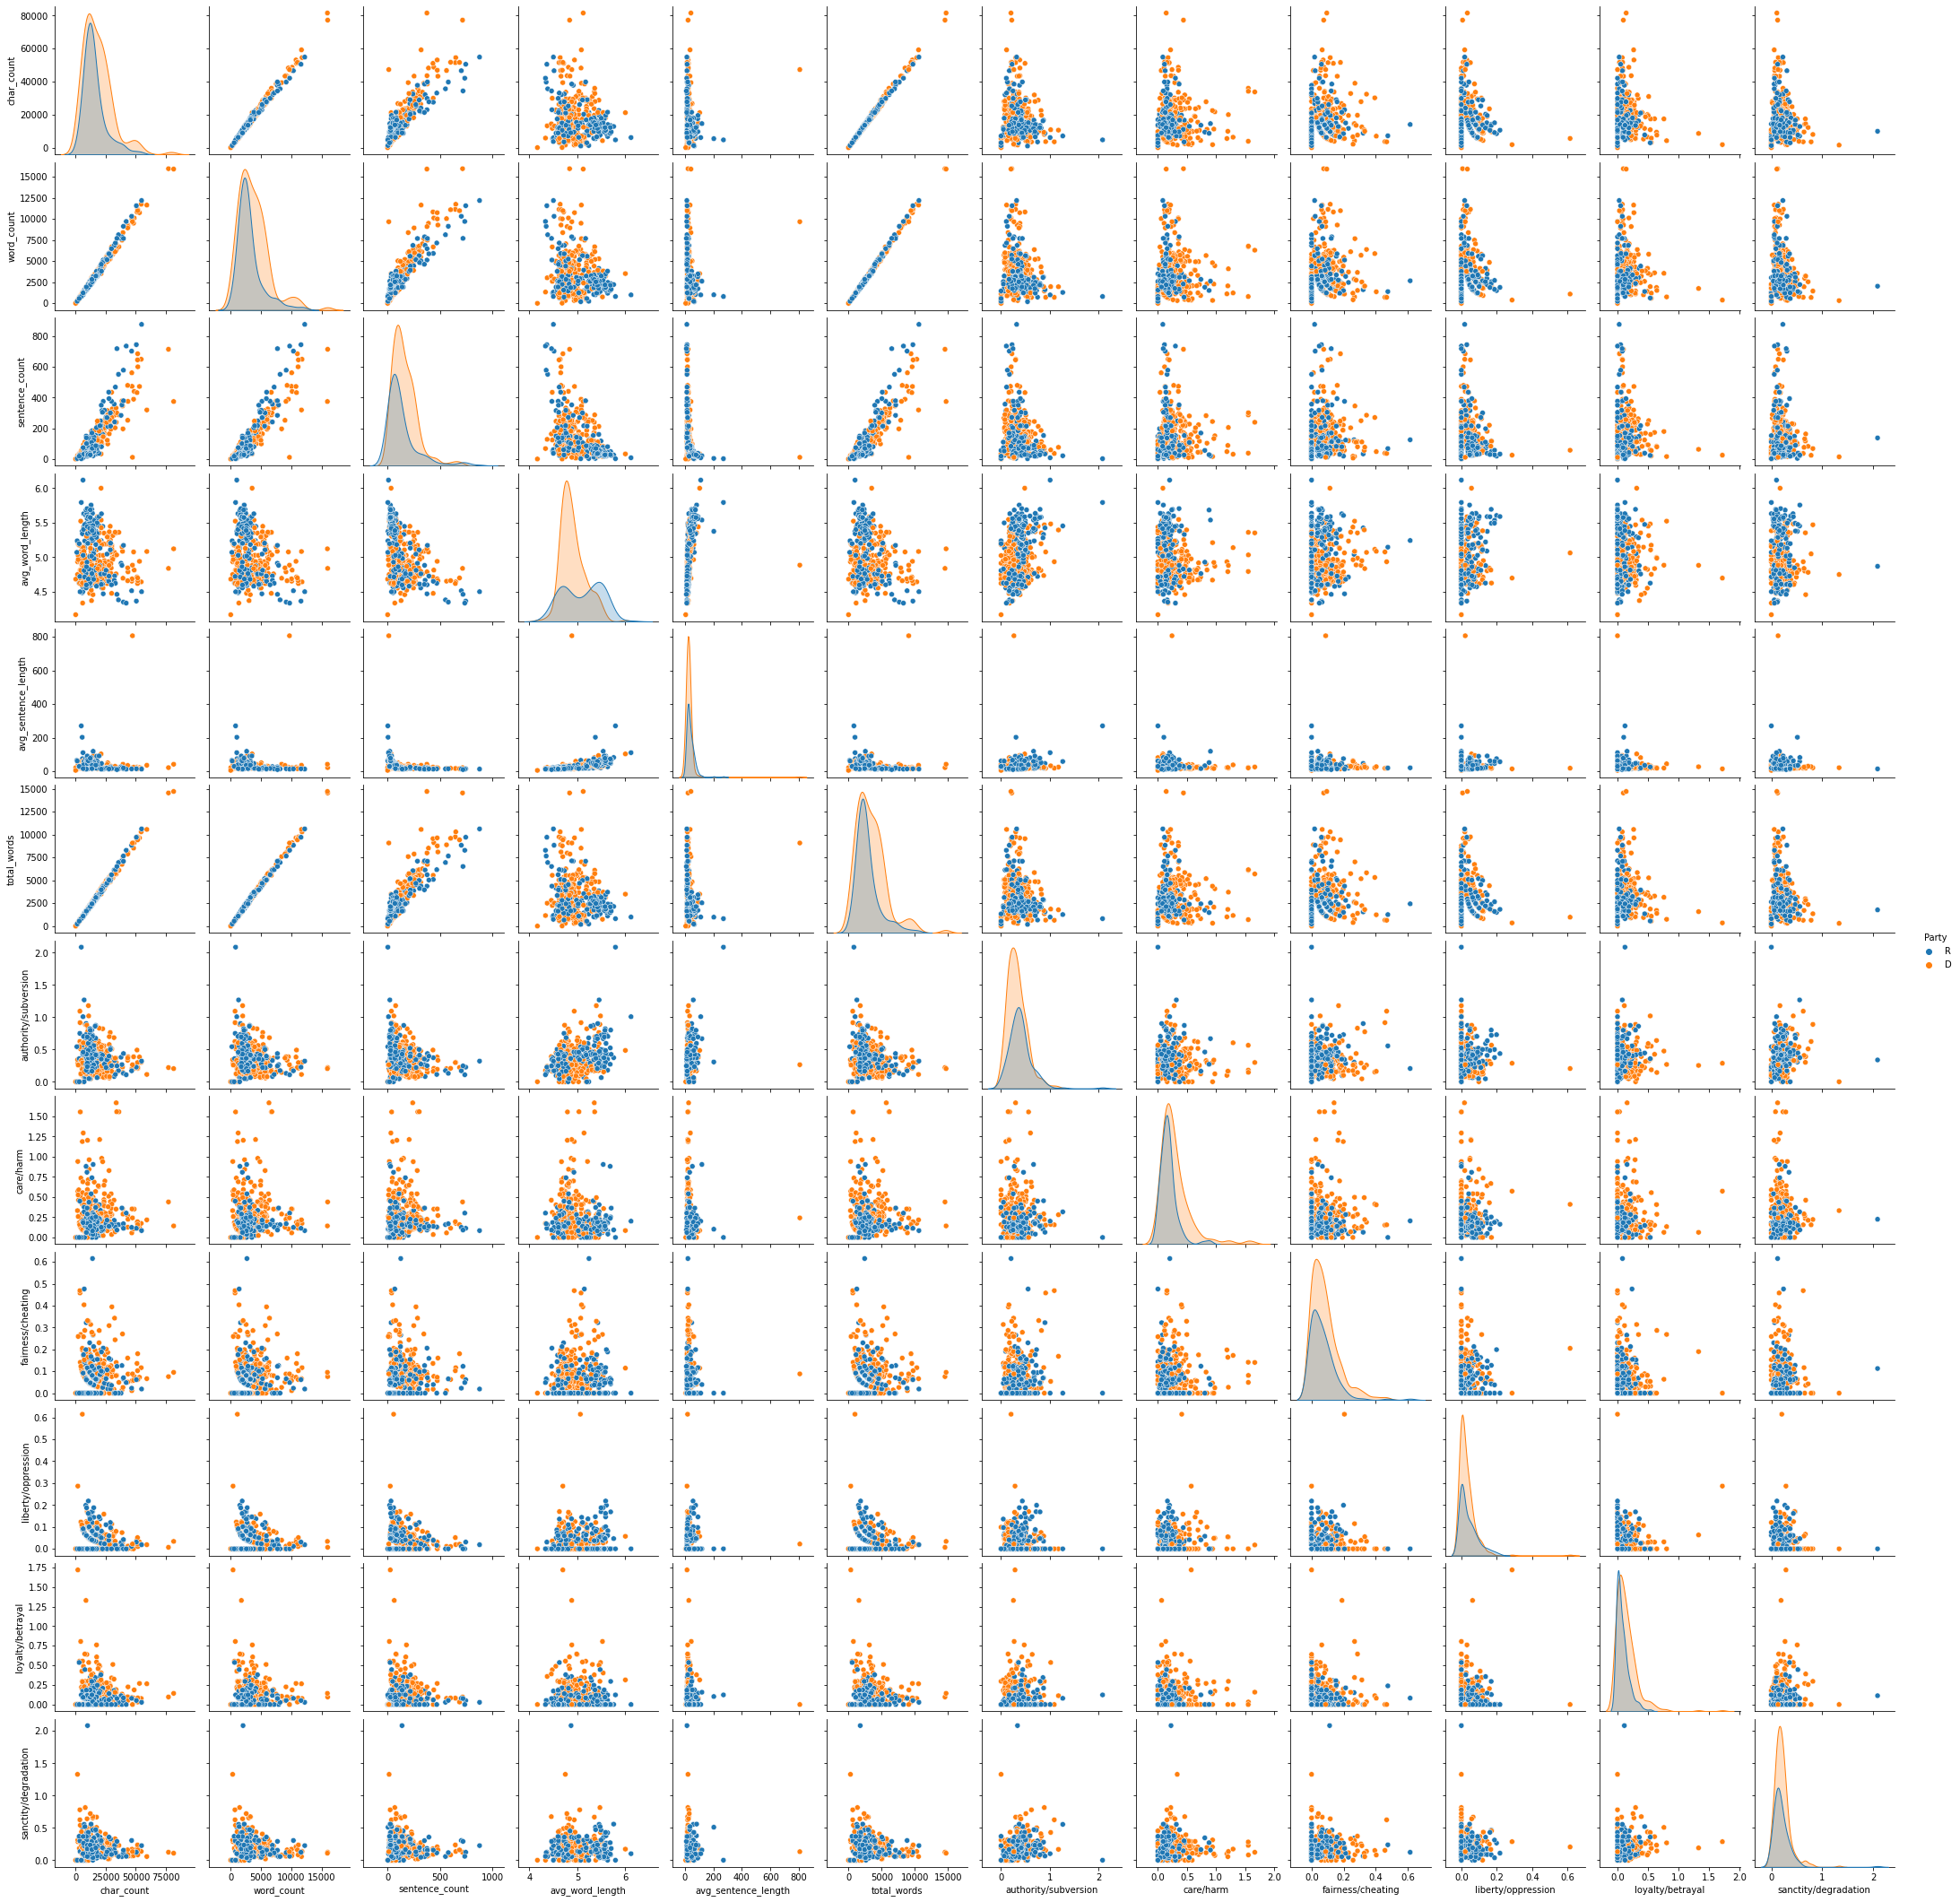

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})
sns.pairplot(campaign, hue="Party")

In-group out-group differences

In [ ]:
def get_moral_party(campaign, moral, party):
    return campaign[campaign['Party'] == party][moral].groupby(campaign[campaign['Party'] == party].Candidate).mean()

def get_moral_party_df(campaign):

    rep_purity = get_moral_party(campaign, "authority/subversion", "R")
    dem_purity = get_moral_party(campaign, "authority/subversion", "D")

    rep_fairness = get_moral_party(campaign, "care/harm", "R")
    dem_fairness = get_moral_party(campaign, "care/harm", "D")

    rep_ingroup = get_moral_party(campaign, "fairness/cheating", "R")
    dem_ingroup = get_moral_party(campaign, "fairness/cheating", "D")

    rep_harm = get_moral_party(campaign, "liberty/oppression", "R")
    dem_harm = get_moral_party(campaign, "liberty/oppression", "D")

    repauth = get_moral_party(campaign, "loyalty/betrayal", "R")
    dem_auth = get_moral_party(campaign, "loyalty/betrayal", "D")

    rep_auth = get_moral_party(campaign, "sanctity/degradation", "R")
    dem_auth = get_moral_party(campaign, "sanctity/degradation", "D")
    
    return pd.DataFrame({
        "rep_purity": rep_purity, "dem_purity": dem_purity,
        "rep_fairness": rep_fairness, "dem_fairness": dem_fairness,
        "rep_harm": rep_harm, "dem_harm": dem_harm,
        "rep_ingroup": rep_ingroup, "dem_ingroup": dem_ingroup,
        "rep_auth": rep_auth, "dem_auth": dem_auth
        })

In [ ]:
moral_heat = get_moral_party_df(campaign)
moral_heat

,rep_purity,dem_purity,rep_fairness,dem_fairness,rep_harm,dem_harm,rep_ingroup,dem_ingroup,rep_auth,dem_auth
Candidate,,,,,,,,,,
Ben Carson,0.102743,NaN,0.229565,NaN,0.078664,NaN,0.000000,NaN,0.078664,NaN
Bernie Sanders,NaN,0.249612,NaN,0.225785,NaN,0.039117,NaN,0.124735,NaN,0.150790
Bobby Jindal,0.349786,NaN,0.155461,NaN,0.000000,NaN,0.000000,NaN,0.116595,NaN
Carly Fiorina,0.543478,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
Chris Christie,0.352694,NaN,0.138866,NaN,0.000000,NaN,0.082560,NaN,1.094174,NaN
Donald Trump,0.440846,NaN,0.188773,NaN,0.042448,NaN,0.060778,NaN,0.193221,NaN
George Pataki,0.504141,NaN,0.180050,NaN,0.144040,NaN,0.072020,NaN,0.180050,NaN
Hillary Clinton,NaN,0.349255,NaN,0.326387,NaN,0.027196,NaN,0.070440,NaN,0.222756
Jeb Bush,0.263235,NaN,0.109633,NaN,0.006536,NaN,0.085980,NaN,0.274695,NaN


Group by candidate

In [ ]:
pc_df = campaign.groupby(campaign.Candidate).mean()
pc_df['Candidate'] = pc_df.index
pc_df

,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation,Candidate
Candidate,,,,,,,,,,,,,
Ben Carson,13446.000000,2923.000000,184.000000,4.681270,17.644596,2534.500000,0.102743,0.229565,0.000000,0.078664,0.145289,0.078664,Ben Carson
Bernie Sanders,16471.800000,3337.700000,134.000000,4.930715,27.028011,2985.316667,0.249612,0.225785,0.124735,0.039117,0.114917,0.150790,Bernie Sanders
Bobby Jindal,13976.000000,2951.000000,185.000000,4.736022,15.951351,2573.000000,0.349786,0.155461,0.000000,0.000000,0.233191,0.116595,Bobby Jindal
Carly Fiorina,1004.000000,198.000000,3.000000,5.070707,66.000000,184.000000,0.543478,0.000000,0.000000,0.000000,0.000000,0.000000,Carly Fiorina
Chris Christie,14689.500000,3073.000000,161.500000,4.802433,18.484920,2792.500000,0.352694,0.138866,0.082560,0.000000,0.187574,1.094174,Chris Christie
Donald Trump,18000.000000,3600.040541,165.148649,5.246845,47.518099,3272.472973,0.440846,0.188773,0.060778,0.042448,0.059008,0.193221,Donald Trump
George Pataki,15070.000000,2961.000000,97.000000,5.089497,30.525773,2777.000000,0.504141,0.180050,0.072020,0.144040,0.036010,0.180050,George Pataki
Hillary Clinton,18899.678571,3881.015306,175.413265,4.866664,22.984024,3501.494898,0.349255,0.326387,0.070440,0.027196,0.152169,0.222756,Hillary Clinton
Jeb Bush,12969.500000,2479.333333,73.166667,5.239596,66.272375,2344.333333,0.263235,0.109633,0.085980,0.006536,0.120090,0.274695,Jeb Bush


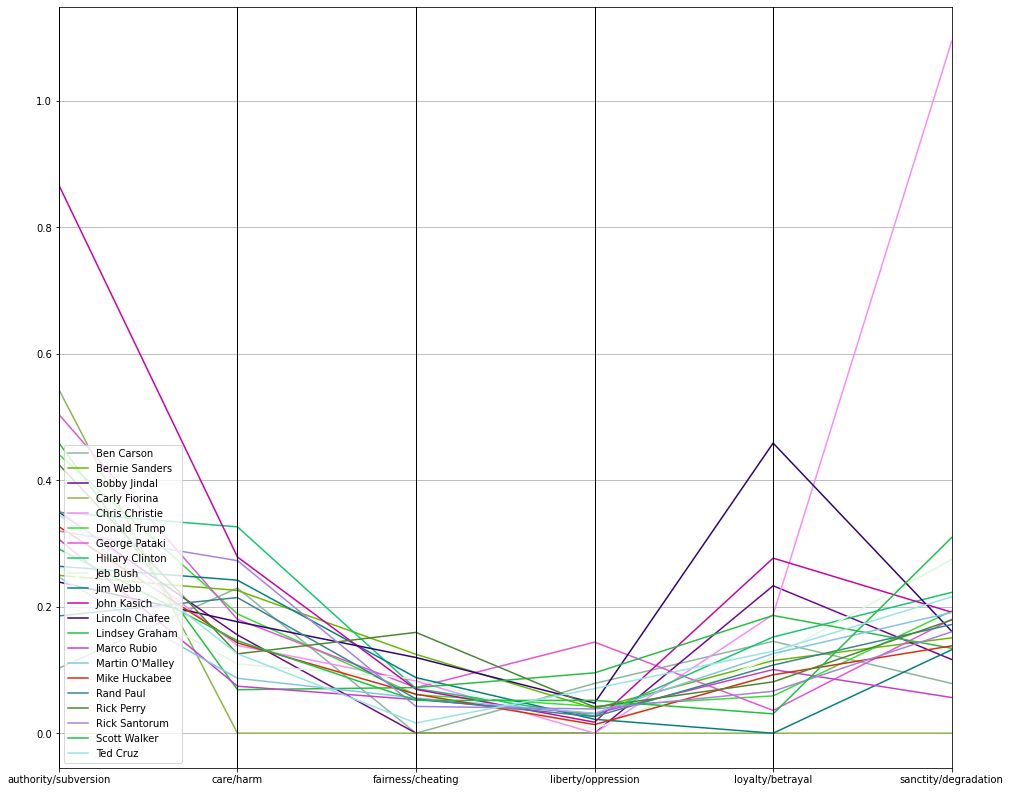

In [ ]:
f, ax = plt.subplots(figsize=(16, 14))
pd.plotting.parallel_coordinates(pc_df, 'Candidate', 
                                 cols=["authority/subversion", "care/harm", "fairness/cheating", "liberty/oppression","loyalty/betrayal", "sanctity/degradation"])
ax.legend(loc="lower left");

Data Filtering by party

We use Boolean indexing to filter out rows of the table that correspond to speeches from other party. 

This can be done through these steps: 

1. identify the correct column 
2. specificy the desired condition for that column 
3. index the Dataframe with that condition in square brackets 

In [ ]:
# Let's take a look on how to create a new table with only Bernie Sanders' speeches

speech_col = campaign['Candidate']

# specify the condition 

sanders_condition = speech_col == 'Bernie Sanders'

# index the original DataFrame by the condition 

sanders_speeches = campaign[sanders_condition]
sanders_speeches.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,...,avg_sentence_length,datetime,clean_speech,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation
5877,Bernie Sanders,D,speech,"April 30, 2015",Interview with Ed Schultz of MSNBC Regarding S...,Schultz: A gentleman who has appeared on the p...,schultz: a gentleman who has appeared on the p...,"[schultz, :, a, gentleman, who, has, appeared,...",[schultz: a gentleman who has appeared on the ...,19597,...,19.018692,2015-04-30,"[schultz, a, gentleman, who, has, appeared, on...",3645,0.329218,0.082305,0.054870,0.027435,0.109739,0.109739
5878,Bernie Sanders,D,speech,"April 30, 2015",Interview with Wolf Blitzer of CNN Regarding S...,Blitzer: I want to move to politics right now ...,blitzer: i want to move to politics right now ...,"[blitzer, :, i, want, to, move, to, politics, ...",[blitzer: i want to move to politics right now...,9538,...,17.623932,2015-04-30,"[blitzer, i, want, to, move, to, politics, rig...",1764,0.566893,0.000000,0.056689,0.170068,0.000000,0.453515
5879,Bernie Sanders,D,speech,"April 30, 2015",Interview with Andrea Mitchell of MSNBC Regard...,Sanders (from video clip): I believe that in a...,sanders (from video clip): i believe that in a...,"[sanders, (, from, video, clip, ), :, i, belie...",[sanders (from video clip): i believe that in ...,5584,...,19.017241,2015-04-30,"[sanders, from, video, clip, i, believe, that,...",976,0.204918,0.409836,0.204918,0.614754,0.000000,0.204918
5880,Bernie Sanders,D,speech,"May 6, 2015","Interview with Chris Cuomo of CNN's ""New Day""","CUOMO: Senator Sanders, welcome to the race. G...","cuomo: senator sanders, welcome to the race. g...","[cuomo, :, senator, sanders, ,, welcome, to, t...","[cuomo: senator sanders, welcome to the race.,...",8412,...,18.708333,2015-05-06,"[cuomo, senator, sanders, welcome, to, the, ra...",1561,0.128123,0.000000,0.192184,0.000000,0.064061,0.064061
5881,Bernie Sanders,D,speech,"May 11, 2015",Interview with Andrea Mitchell of MSNBC,MITCHELL: Vermont Senator and Democratic presi...,mitchell: vermont senator and democratic presi...,"[mitchell, :, vermont, senator, and, democrati...",[mitchell: vermont senator and democratic pres...,5156,...,17.864407,2015-05-11,"[mitchell, vermont, senator, and, democratic, ...",910,0.219780,0.000000,0.000000,0.109890,0.000000,0.219780


**Analysis on the Democrats**

In [ ]:
# let's create a table that only contains Democrats using boolean indexing

# We start by filtering out non-Democrat speeaches

party_col = campaign['Party']

dem_cond = party_col =='D'

democrats = campaign[dem_cond]

democrats.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,...,avg_sentence_length,datetime,clean_speech,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation
436,Lincoln Chafee,D,speech,"June 3, 2015",Remarks Announcing Candidacy for President at ...,"Thank you, Bob. Thank you, Bob and Mark, very ...","thank you, bob. thank you, bob and mark, very ...","[thank, you, ,, bob, ., thank, you, ,, bob, an...","[thank you, bob., thank you, bob and mark, ver...",30480,...,18.666667,2015-06-03,"[thank, you, bob, thank, you, bob, and, mark, ...",5512,0.235849,0.181422,0.090711,0.036284,0.145138,0.108853
437,Lincoln Chafee,D,speech,"July 17, 2015",Remarks at the Iowa Democrats Hall of Fame Din...,Congratulations to the Hall of Fame Inductees....,congratulations to the hall of fame inductees....,"[congratulations, to, the, hall, of, fame, ind...",[congratulations to the hall of fame inductees...,4220,...,44.941176,2015-07-17,"[congratulations, to, the, hall, of, fame, ind...",745,0.268456,0.134228,0.268456,0.000000,0.805369,0.268456
438,Lincoln Chafee,D,speech,"October 23, 2015",Remarks Announcing the End of Presidential Cam...,Once again it is a pleasure to join so many De...,once again it is a pleasure to join so many de...,"[once, again, it, is, a, pleasure, to, join, s...",[once again it is a pleasure to join so many d...,5203,...,28.083333,2015-10-23,"[once, again, it, is, a, pleasure, to, join, s...",939,0.212993,0.212993,0.000000,0.106496,0.425985,0.106496
570,Hillary Clinton,D,speech,"January 20, 2007",Video Transcript: Presidential Exploratory Com...,HILLARY CLINTON: I announced today that I am f...,hillary clinton: i announced today that i am f...,"[hillary, clinton, :, i, announced, today, tha...",[hillary clinton: i announced today that i am ...,1832,...,15.000000,2007-01-20,"[hillary, clinton, i, announced, today, that, ...",349,0.286533,0.573066,0.000000,0.286533,1.719198,0.286533
571,Hillary Clinton,D,speech,"January 22, 2007","Remarks in a ""Let the Conversation Begin Webcast""","SENATOR CLINTON: Hi, everyone, and welcome to ...","senator clinton: hi, everyone, and welcome to ...","[senator, clinton, :, hi, ,, everyone, ,, and,...","[senator clinton: hi, everyone, and welcome to...",27981,...,21.889299,2007-01-22,"[senator, clinton, hi, everyone, and, welcome,...",5349,0.355207,0.261731,0.037390,0.018695,0.149561,0.093475


Now that we have our percentages for the Democractic party, we can view the average percents for Democracts as a group. 

In [ ]:
from pandas.core import apply
# we select the foundations columns and calculate the mean percent for each 

avg_dem_stats = (democrats.loc[:, list(mft_dict.keys())]
                 .apply(np.mean)
                 .to_frame('D_percent'))

avg_dem_stats

,D_percent
authority/subversion,0.321495
care/harm,0.292418
fairness/cheating,0.082472
liberty/oppression,0.030215
loyalty/betrayal,0.145686
sanctity/degradation,0.204513


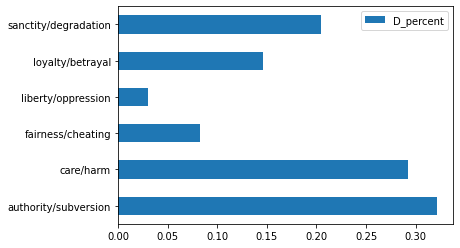

In [ ]:
# let's create a horixontal bar plot using the .plot.barh() method on avg_dem_stats

avg_dem_stats.plot.barh()

**Republicans Analysis**

In [ ]:
# we repeat the same analysis before to get the percent avg for the republican part

# Select the republican party column from the dataframe
party_col = campaign['Party']

# create a boolean expression/condition that checks if the a party is Republican
republican_cond = party_col == 'R'

# index the dataframe using 'republican_cond'
republicans = campaign[republican_cond]

republicans.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,...,avg_sentence_length,datetime,clean_speech,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,...,49.744681,2015-06-15,"[thank, you, all, very, much, i, always, feel,...",2284,0.175131,0.175131,0.131349,0.000000,0.306480,0.175131
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,...,22.761905,2015-07-30,"[thank, you, all, very, much, i, appreciate, y...",2638,0.303260,0.075815,0.265353,0.000000,0.151630,0.341168
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,...,30.765152,2015-08-11,"[thank, you, very, much, it, s, good, to, be, ...",3735,0.321285,0.133869,0.026774,0.000000,0.107095,0.133869
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,...,22.065217,2015-09-09,"[thank, you, very, much, i, appreciate, your, ...",1880,0.159574,0.053191,0.053191,0.000000,0.053191,0.212766
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,...,69.297297,2015-11-02,"[thank, you, it, s, great, to, be, in, tampa, ...",2550,0.313725,0.117647,0.039216,0.039216,0.000000,0.274510


In [ ]:
# calculating the averages 

# select the foundations columns and calculate the mean percent for each
avg_rep_stats = (republicans.loc[:, list(mft_dict.keys())]
                 .apply(np.mean)
                 .to_frame('R_percent'))

avg_rep_stats 

,R_percent
authority/subversion,0.393636
care/harm,0.176955
fairness/cheating,0.066454
liberty/oppression,0.039025
loyalty/betrayal,0.080041
sanctity/degradation,0.191499


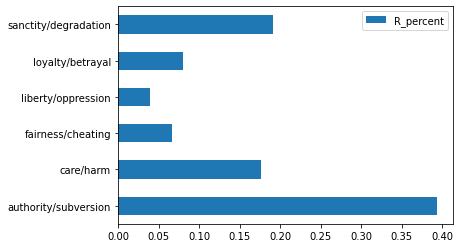

In [ ]:
# your code here
avg_rep_stats.plot.barh()

**Comparing the groups**

In [ ]:
# we comine the avg stats on both parties using the join function .join

all_avg_stats = avg_dem_stats.join(avg_rep_stats)
all_avg_stats

,D_percent,R_percent
authority/subversion,0.321495,0.393636
care/harm,0.292418,0.176955
fairness/cheating,0.082472,0.066454
liberty/oppression,0.030215,0.039025
loyalty/betrayal,0.145686,0.080041
sanctity/degradation,0.204513,0.191499


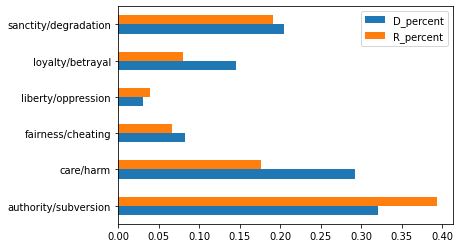

In [ ]:
# we plot the avg stats for both parties 

all_avg_stats.plot.barh()

Observations

We see the bar lengths are very similar which makes it difficult to make inferences or comparison judgments on differences. 

To make clear comparisons, we create a plot of only the difference in avergae foundation word usage of Democrats and Republicans. 

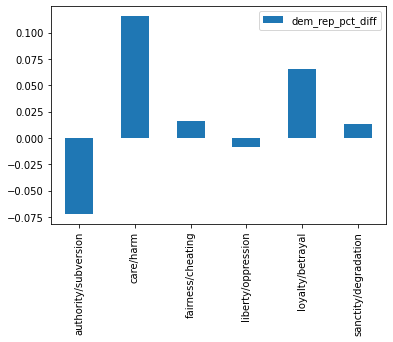

In [ ]:
party_diffs = pd.DataFrame(data = avg_dem_stats['D_percent'] - avg_rep_stats['R_percent'],
                          columns = ["dem_rep_pct_diff"], 
                          index = mft_dict.keys())
party_diffs.plot.bar()

The positive value means Democracts using the word more frequently while a negative value indicates Republicans use it more frequently

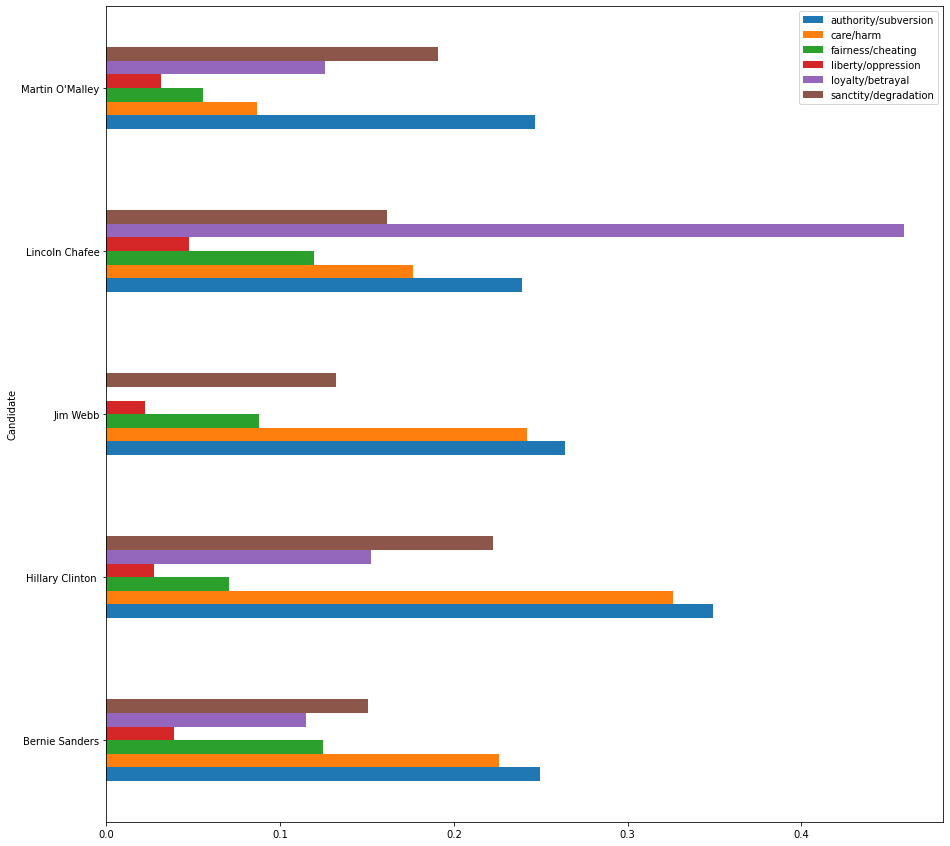

In [ ]:
# We look at the candidates individually to compare the average use of foundation words by individual Democrats

dem_indivs = (democrats.loc[:, list(mft_dict.keys()) + ['Candidate']]
             .groupby('Candidate')
             .mean())

dem_indivs.plot.barh(figsize=(15, 15))

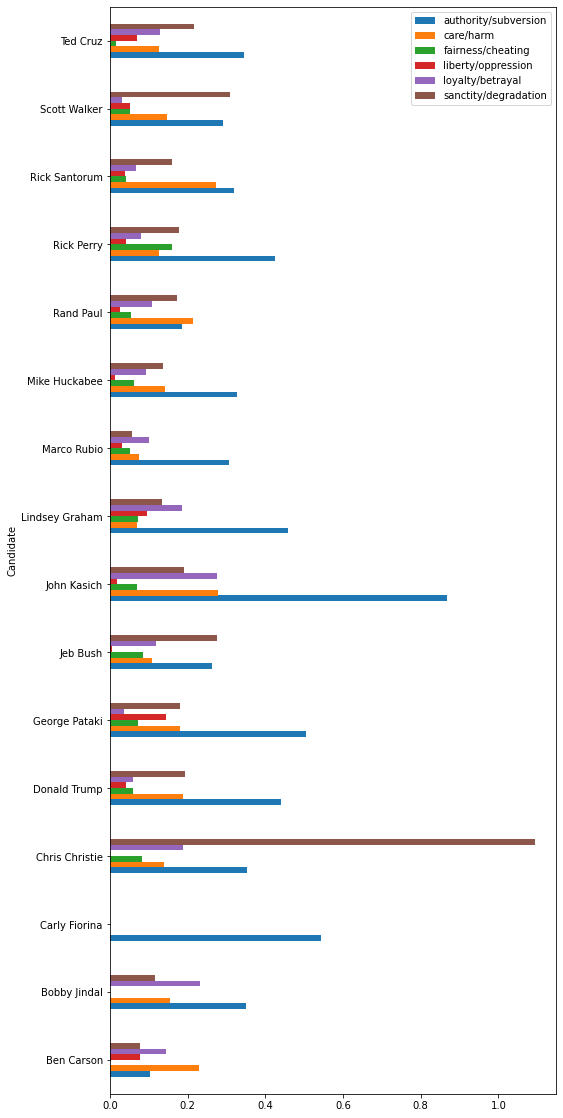

In [ ]:
# and for individual republicans 

rep_indivs = (republicans.loc[:, list(mft_dict.keys()) + ['Candidate']]
             .groupby('Candidate')
             .mean())

rep_indivs.plot.barh(figsize=(8, 20))

**Incorporating temporal analysis to examine how a candidate use foundation words over time.**

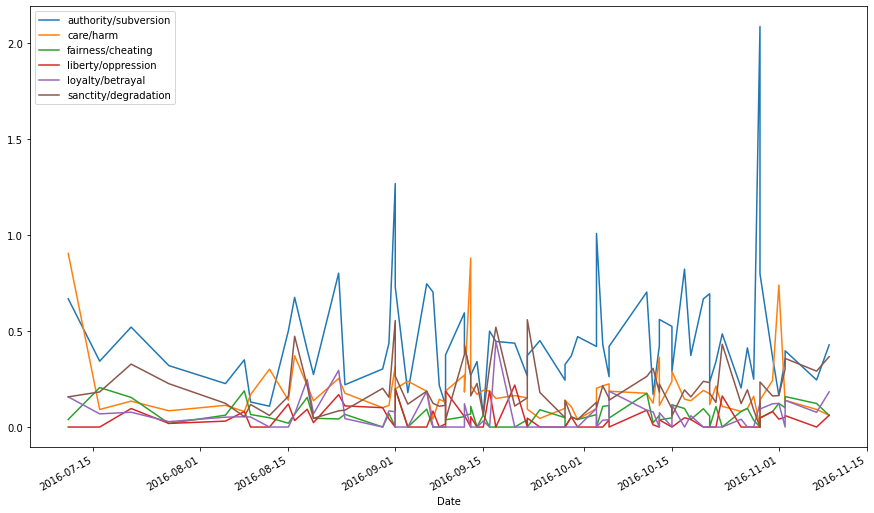

In [ ]:
# Doland Trump

trump = (republicans[republicans['Candidate'] == "Donald Trump"]
         .loc[:, list(mft_dict.keys()) + ['Date']])

# set the speech dates as the table index
trump['Date'] = pd.to_datetime(trump['Date'])
trump = (trump.set_index('Date')
         .loc['2016-07-01':])

# plot the data
trump.plot(figsize = (15, 9))

# Clustering 

There seems to be two types of morality varying by candidate. Let's see which candidates fall into which morality clusters

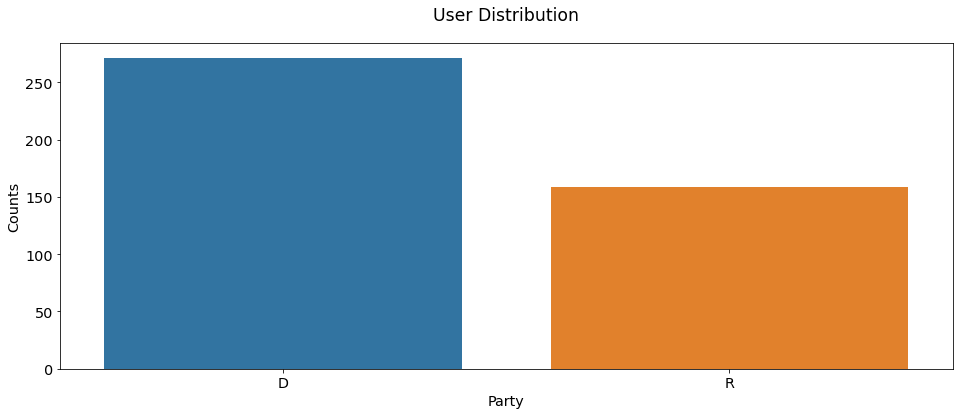

In [ ]:
#let's first view our user distribution


users = campaign['Party'].unique().tolist()

users_distrib = campaign['Party'].value_counts()

plt.figure(figsize=(16, 6))
ax = sns.barplot(x=users_distrib.index, y=users_distrib.values)

plt.setp(ax.xaxis.get_label(), fontsize='x-large');
plt.setp(ax.yaxis.get_label(), fontsize='x-large');

ax.set_title("User Distribution", fontsize="xx-large", y=1.05)
ax.set_xlabel("Party", fontsize="x-large")
ax.set_ylabel("Counts", fontsize="x-large")

plt.setp(ax.get_xticklabels(), fontsize='x-large');
plt.setp(ax.get_yticklabels(), fontsize='x-large');

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
train = campaign.drop(columns=['Candidate', 'Party', 'Type',
                               'Date', 'Title', 'Text',
                               'word_count', 'sentence_count', 'avg_word_length',
                               'clean_text', 'words', 'sentences',
                               'char_count', 'avg_sentence_length', 'datetime',
                               'clean_speech', 'total_words'])
train.head()

,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation
0,0.175131,0.175131,0.131349,0.000000,0.306480,0.175131
1,0.303260,0.075815,0.265353,0.000000,0.151630,0.341168
2,0.321285,0.133869,0.026774,0.000000,0.107095,0.133869
3,0.159574,0.053191,0.053191,0.000000,0.053191,0.212766
4,0.313725,0.117647,0.039216,0.039216,0.000000,0.274510


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(train)

In [ ]:
len(kmeans.labels_)

430

Assigning candidates to clusters

In [ ]:
df_clustered = campaign

In [ ]:
df_clustered['Cluster'] = kmeans.labels_
df_clustered.head()

,Candidate,Party,Type,Date,Title,Text,clean_text,words,sentences,char_count,...,datetime,clean_speech,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation,Cluster
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,...,2015-06-15,"[thank, you, all, very, much, i, always, feel,...",2284,0.175131,0.175131,0.131349,0.000000,0.306480,0.175131,0
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,...,2015-07-30,"[thank, you, all, very, much, i, appreciate, y...",2638,0.303260,0.075815,0.265353,0.000000,0.151630,0.341168,0
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,...,2015-08-11,"[thank, you, very, much, it, s, good, to, be, ...",3735,0.321285,0.133869,0.026774,0.000000,0.107095,0.133869,0
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,...,2015-09-09,"[thank, you, very, much, i, appreciate, your, ...",1880,0.159574,0.053191,0.053191,0.000000,0.053191,0.212766,0
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,...,2015-11-02,"[thank, you, it, s, great, to, be, in, tampa, ...",2550,0.313725,0.117647,0.039216,0.039216,0.000000,0.274510,0


Discrete cluster assignement

In [ ]:
clusters = df_clustered.groupby('Candidate').Cluster.mean().round()
cluster_map = {0: "a", 1:"b"}
clusters_mapped = clusters.map(cluster_map)
clusters_mapped

Candidate
Ben Carson          a
Bernie Sanders      a
Bobby Jindal        a
Carly Fiorina       a
Chris Christie      a
Donald Trump        a
George Pataki       a
Hillary Clinton     a
Jeb Bush            a
Jim Webb            a
John Kasich         a
Lincoln Chafee      a
Lindsey Graham      a
Marco Rubio         a
Martin O'Malley     a
Mike Huckabee       a
Rand Paul           a
Rick Perry          a
Rick Santorum       a
Scott Walker        a
Ted Cruz            a
Name: Cluster, dtype: object

In [ ]:
print("Candidates with morality a : \n", clusters_mapped[clusters_mapped == 'a'])

Candidates with morality a : 
 Candidate
Ben Carson          a
Bernie Sanders      a
Bobby Jindal        a
Carly Fiorina       a
Chris Christie      a
Donald Trump        a
George Pataki       a
Hillary Clinton     a
Jeb Bush            a
Jim Webb            a
John Kasich         a
Lincoln Chafee      a
Lindsey Graham      a
Marco Rubio         a
Martin O'Malley     a
Mike Huckabee       a
Rand Paul           a
Rick Perry          a
Rick Santorum       a
Scott Walker        a
Ted Cruz            a
Name: Cluster, dtype: object


In [ ]:
print("Candidates with morality b : \n", clusters_mapped[clusters_mapped == 'b'])

Candidates with morality b : 
 Series([], Name: Cluster, dtype: object)


Assigning continuous values based on mean of cluster class

In [ ]:
cluster_cont = df_clustered.groupby('Candidate').Cluster.mean()
result = pd.DataFrame({"candidate": cluster_cont.index, "mean_moral":cluster_cont})
result = result.sort_values(by=['mean_moral'])
result

,candidate,mean_moral
Candidate,,
Ben Carson,Ben Carson,0.000000
Rick Perry,Rick Perry,0.000000
Rand Paul,Rand Paul,0.000000
Mike Huckabee,Mike Huckabee,0.000000
Martin O'Malley,Martin O'Malley,0.000000
Marco Rubio,Marco Rubio,0.000000
Lindsey Graham,Lindsey Graham,0.000000
Lincoln Chafee,Lincoln Chafee,0.000000
Scott Walker,Scott Walker,0.000000


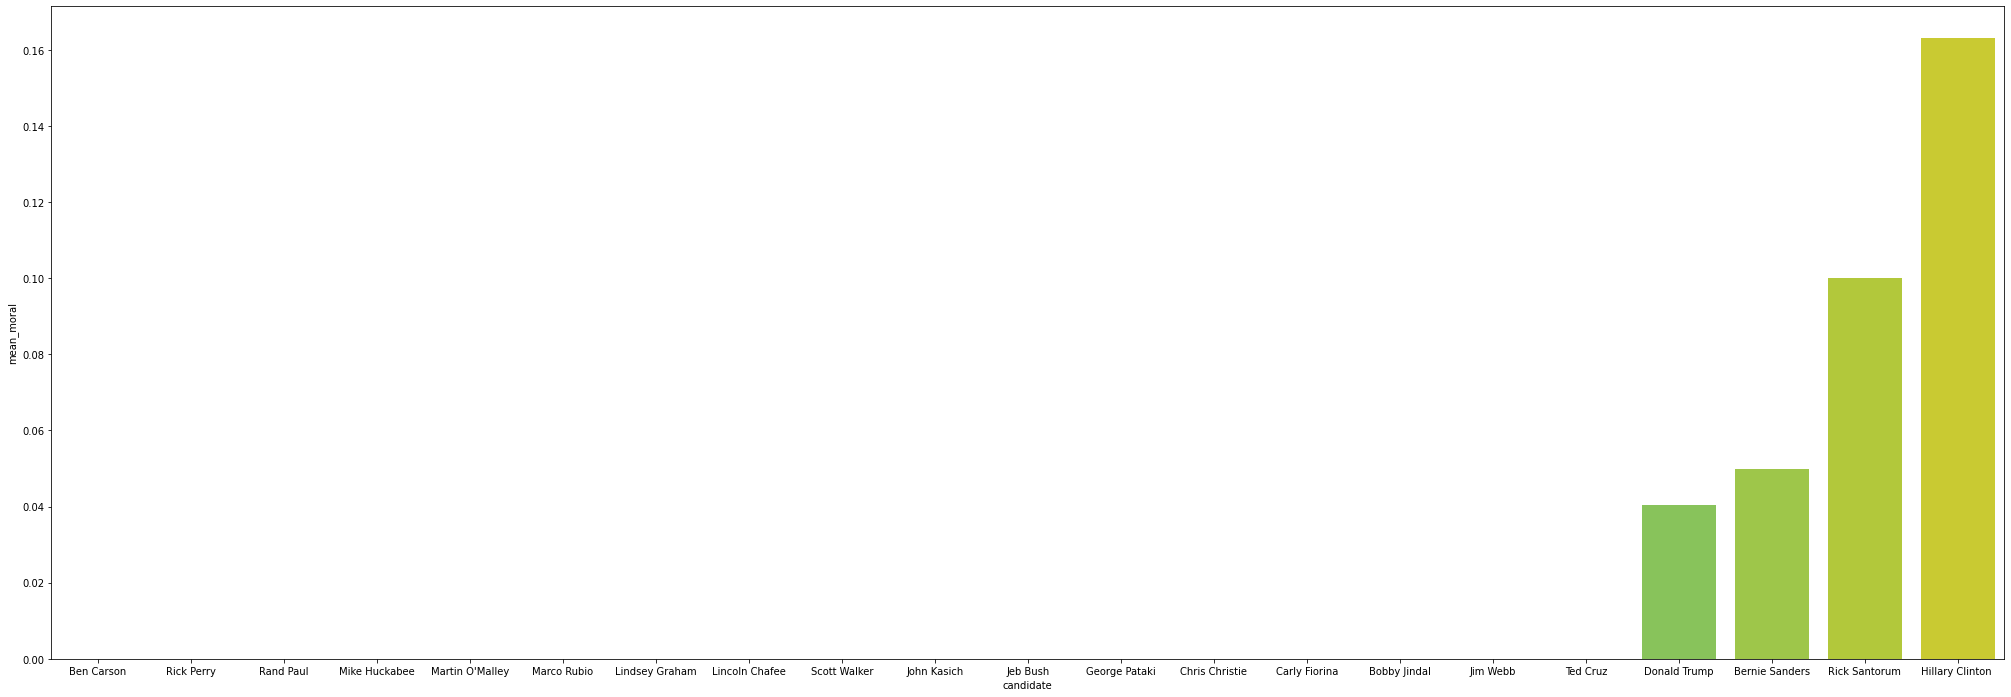

In [ ]:
f, ax = plt.subplots(figsize=(35, 12))
sns.barplot(x='candidate', y='mean_moral',data=result, palette="viridis");

This represents candidates morality along a continuum from prevalence of morality a to b (not which candiates are "more moral")